## Load the environment

---

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from ppo_controller import PPOController
from ddpg_controller import DDPGController
from nstep_ddpg_controller import NStepDDPGController
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='../Reacher_20/Reacher.app')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
def rolling_avg_scores(scores, window):
    if len(scores) <= window:
        return [np.mean(scores)]
    else:
        return [np.mean(scores[x:x+window]) for x in range(len(scores) - window + 1)]

def plot_results(series, names):
    for serie, name in zip(series, names):
        plt.plot(np.arange(len(serie)), serie)
        plt.plot(np.arange(19, len(serie)), rolling_avg_scores(serie, 20))
        plt.ylabel(name)
        plt.xlabel('Episode #')
        plt.show()

## PPO agent

---

Episode 1200/1200 | Average Score: 31.79 | Model surrogate: 0.47684   

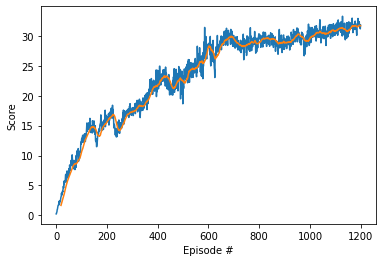

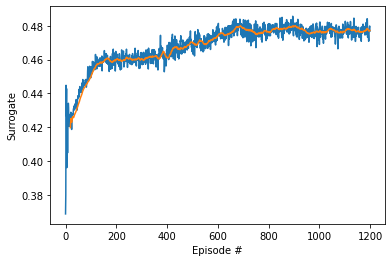

In [5]:
class Config:
    def __init__(self):
        self.state_size = 33
        self.action_size = 4
        self.num_agents = 20
        
        self.num_episodes = 1200
        self.std = 0.5
        self.epsilon_start = 0.1
        self.epsilon_decay = 1
        self.learning_rate = 5e-4
        self.train_iterations = 4
        self.gamma = 0.99
        self.mlp_specs = (200, 150, 150)
        self.update_every = 200
        self.max_memory = 200
        self.tau = 1e-3
        
    def as_dict(self):
        return self.__dict__
    

ppo_controller = PPOController(env, brain_name, Config())
ppo_scores, surrogates = ppo_controller.solve()
plot_results((ppo_scores, surrogates), ('Score', 'Surrogate'))

## DDPG agent

---

Episode 200/200 | Average Score: 36.35 | Surrogate: -1.47434 | Critic loss: 0.00219  

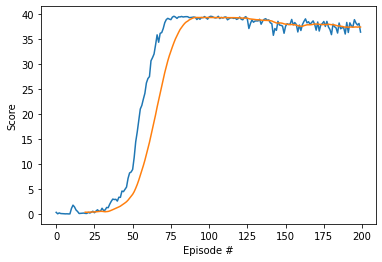

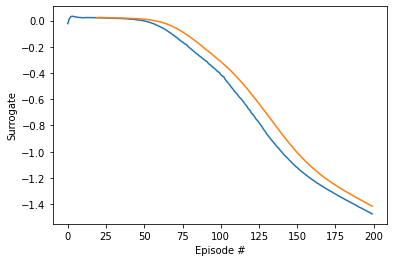

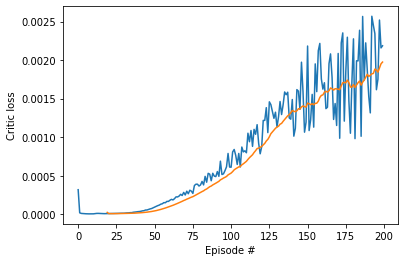

In [8]:
class Config:
    def __init__(self):
        self.state_size = 33
        self.action_size = 4
        self.num_agents = 20
        
        self.num_episodes = 200
        self.batch_size = 64
        self.learning_rate = 5e-4
        self.gamma = 0.99
        self.mlp_specs = (200, 150)
        self.update_every = 4
        self.max_memory = 1e5
        self.tau = 1e-3
        
    def as_dict(self):
        return self.__dict__
    

ddpg_controller = DDPGController(env, brain_name, Config())
ddpg_scores, surrogates, critic_losses = ddpg_controller.solve()
plot_results((ddpg_scores, surrogates, critic_losses), ('Score', 'Surrogate', 'Critic loss'))

## DDPG agent with n_step

---

Episode 200/200 | Average Score: 36.82 | Surrogate: -2.97299 | Critic loss: 0.02096  

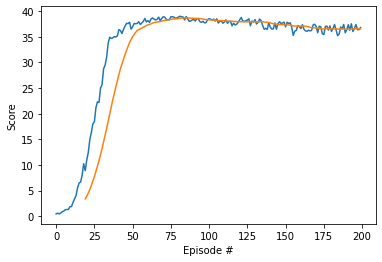

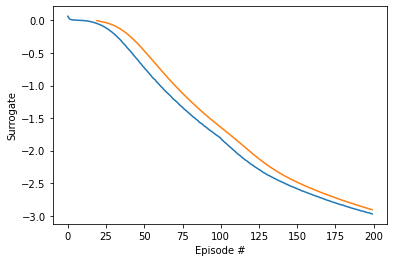

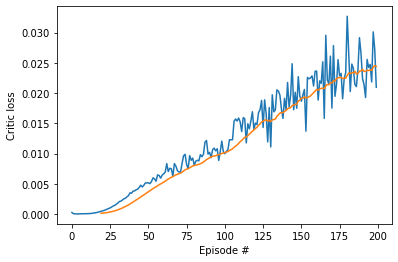

In [9]:
class Config:
    def __init__(self):
        self.state_size = 33
        self.action_size = 4
        self.num_agents = 20
        
        self.num_episodes = 200
        self.batch_size = 64
        self.n_step = 3
        self.learning_rate = 5e-4
        self.gamma = 0.99
        self.mlp_specs = (200, 150)
        self.update_every = 4
        self.max_memory = 1e5
        self.tau = 1e-3
        
    def as_dict(self):
        return self.__dict__
    

nstep_ddpg_controller = NStepDDPGController(env, brain_name, Config())
nstep_ddpg_scores, surrogates, critic_losses = nstep_ddpg_controller.solve()
plot_results((nstep_ddpg_scores, surrogates, critic_losses), ('Score', 'Surrogate', 'Critic loss'))

## Comparing results

---

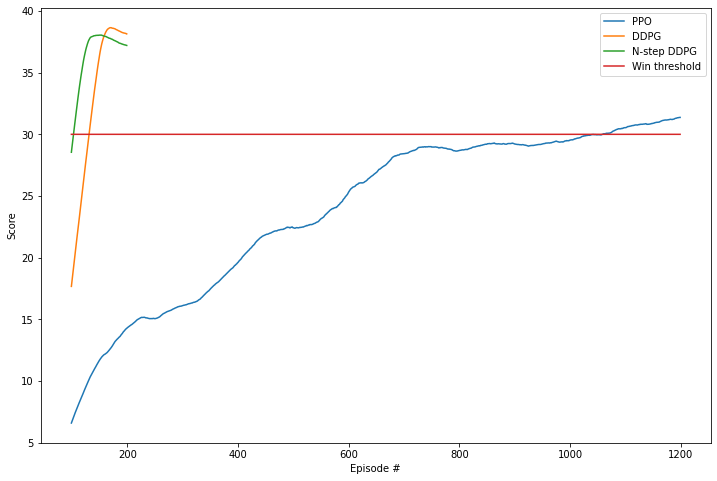

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(range(99, 1200), rolling_avg_scores(ppo_scores, 100), label='PPO')
plt.plot(range(99, 200), rolling_avg_scores(ddpg_scores, 100), label='DDPG')
plt.plot(range(99, 200), rolling_avg_scores(nstep_ddpg_scores, 100), label='N-step DDPG')
plt.plot(range(99, 1200), np.ones(1101) * 30, label='Win threshold')
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.legend()
plt.show()

## Save successful model

---

In [12]:
import torch
torch.save(nstep_ddpg_controller.trained_critic.state_dict(), 'critic_checkpoint.pth')
torch.save(nstep_ddpg_controller.trained_policy.state_dict(), 'policy_checkpoint.pth')